# Session 3

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import *
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import *
from sklearn.metrics import roc_curve, auc

### Spam Data

In this session, we will use classifiers to detect email spam. The dataset is provided by the authors of the book [Elements of Statistical Learning](http://statweb.stanford.edu/~tibs/ElemStatLearn/). The dataset has got 57 continuous features and a binary response. Since the elements are separated by spaces, we will use the regular expression for whitespace characters to import the data into Pandas.

In [2]:
df = pd.read_csv('https://web.stanford.edu/~hastie/ElemStatLearn/datasets/spam.data', 
                 engine='python', sep='\\s', header=None)
feat_index = list(range(57))
df.columns = feat_index+['Spam']
df.head()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,Spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


### Cross Validation: Shuffle Split
Instead of using k-fold cross validation, we will use a simple shuffle split that randomly separates the data into 3 parts training data and 1 part test data.

In [3]:
X = df[feat_index].values
y = df.Spam.values

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

## Bayes Classifier

Denote $P(y=k)$ as the (prior) probability of observation $y$ being a member of class $k$, $P(x=X)$ as the probability of observing $x$, and $P(X=k|y=k)$ as the (posterior) probability of observing $x$ given class $y$. Then using Bayes's rule, we can define the conditional probability of an observation belonging to class $k$ given $x$ as

$$P(y=k|X=k)= \frac{P(Y=y)P(X=x|y=k)}{P(X=x)}$$

A new observation $x$ can be classified by choosing the class $k$, for which $P(y=k|X=k)$ is largest. Since $P(X=x)$ is independent of $k$, we can drop the denominator and select the class $k$ that maximizes

$$P(y=k|X=x) = P(y=k) P(X=x|y=k)$$

The Bayes classfier has the lowest possible error rate among all classfiers if we can specify the correct probabilities. Since this is rarely possible for real data, we must make certain assumptions about the data and develop an approximation of the Bayes classfier. One such approach is linear discriminant analysis (LDA).

### Linear Discriminant Analysis

If we assume that the conditional probability of class membership follows a normal distribution with identical covariance matrix, the Bayes optimal classifier is to assign an observation to the class with the higher liklihood. A more detailed explanation can be found in Chapters 4.4.2 and 4.4.3 of [Introduction to Statsitical Learning](http://www-bcf.usc.edu/~gareth/ISL)

In [5]:
clf1 = LinearDiscriminantAnalysis()
clf1.fit(X_train, y_train)
accuracy = clf1.score(X_test, y_test)
"accuracy: %.1f percent"%(100*accuracy)

'accuracy: 86.8 percent'

### Quadratic Discriminant Analysis

If we drop the assumption of having one identical covariance matrix, but rather allow each class to have its covariance matrix, we arrive at quadratic discriminant analysis (QDA).

In [6]:
clf2 = QuadraticDiscriminantAnalysis()
clf2.fit(X_train, y_train)
accuracy = clf2.score(X_test, y_test)
"accuracy: %.1f percent"%(100*accuracy)

'accuracy: 83.2 percent'

In our case QDA is worse than LDA, which shows that using a more complex learner is not always better, as it typically requires more parameters to set. In this case, we must estimate parameters for two covariance matrices as opposed to one.

### Naive Bayes

We can also go the other direction by assuming that all features are independent. In this case, the Bayes classifier can be greatly simplified and we no further need to estimate a covariance matrix, but rather need to compute mean and standard deviation for each feature and class. Although this approach represents an extreme simplification, which is why it is called Naive Bayes, the method scales extremely well across thousands of features.

In [7]:
clf3 = GaussianNB()
clf3.fit(X_train, y_train)
accuracy = clf3.score(X_test, y_test)
"accuracy: %.1f percent"%(100*accuracy)

'accuracy: 82.3 percent'

Although it has much fewer parameters, Naive Bayes is at par with QDA. This demonstrates that despite its simplicity, Naive Bayes provides a good the benchmark against which any other more complex classifier can be compared. If a more complex learner does not outperform a simple learner, the simple learner is to be preferred. In our case Naive Bayes is to be preferred over QDA.

## The ROC Curve

A receiver operating characteristic (ROC) curve, is a graph that visualizes the accuracy of a binary classifier with varying discrimination threshold. The ROC curve plots the true positive rate (TPR) against the false positive rate (FPR) for different thresholds, i.e. the value at which the class label changes or the posterior probability. The area under the curve (AUC) thereby provides information about the optimality of a classifier and can be used to select classification models. 

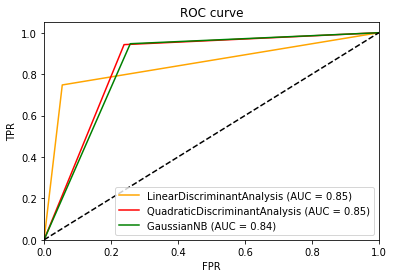

In [8]:
plt.figure()
colors = {clf1: "orange", clf2: "red", clf3: "green"}
for clf in [clf1,clf2,clf3]:
    roc = roc_curve(y_test,clf.predict(X_test))
    area = auc(roc[0], roc[1])
    plt.plot(roc[0], roc[1], 
             color=colors[clf],
             label='%s (AUC = %0.2f)'%(clf.__class__.__name__,area))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

## Nearest Neighbor Classifier

One of the most basic classifiers is the nearest neighbor classifier. Unlike the Bayesian classifiers or logistic regression, nearest neighbor is not model based, but used the data itself for prediction. Nearest neighbor is quite simple. All it takes is some measure of similarity, like the distance between the feature vectors, then new observations are classified by taking the class (the majority class) of the nearest neighbor (neighbors).

In [9]:
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
"accuracy: %.1f percent"%(100*accuracy)

'accuracy: 78.9 percent'

The nearest neighbor classifier is highly sensitive towards the similarity measure. If, for instance, the Euclidean distance is used, features that have the larger scale also have a larger effect on the distance. This means that features with larger scales implicitly receive a higher weight than data with a smaller scale.

For example, assume one feature is income with observations ranging from \$10,000 to \$250,000, whereas another features is temperature with observations ranging from -10°C to 40°C. Any new observation is compared with all other observations by measuring the Euclidean distance between the feature vectors, i.e.,

$$d(x_1,x_2) = \sqrt{\sum_{j=1}^p (x_{1j}-x_{2j})^2}$$

It is quite obvious that $(250000-10000)^2$ contributes more to the distance than of $(-10-40)^2$, even though both mark the boundaries of the sample space.

### Scaling
A popular solution to this problem is scaling, whereby the most common type of scaling is normalization.

Denote $x_{ij}$ as the $j$-th predictor of the $i$-th observation, with $\mu_j$ as its mean and $\sigma_j$ as the standard deviation. Then the standardized observation $z_{ij}$ is given by

$$ z_{ij}= \frac{x_{ij}-\mu_j}{\sigma_j}, \ j=1,\dots,p,\ i=1,\dots,n$$

Although the boundaries of the data may still deviate the average distance in each dimension is now equal to one. An alternative to using the standard deviation is to use the inter-quartile range, which may be beneficial in the presence of outliers. Also see: http://scikit-learn.org/stable/modules/preprocessing.html

Let us scale our data using scikit's *StandardScaler*.

In [10]:
scaler = StandardScaler().fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

After scaling the accuracy of the nearest neighbor classfier gas increased from about 80 to 90 percent, which is at par with LDA and logistic regression. (Note that the accuracy figures deviate depending on which observations are used for training and which for testing.)

In [11]:
clf = KNeighborsClassifier()
clf.fit(X_train_sc, y_train)
accuracy = clf.score(X_test_sc, y_test)
"accuracy: %.1f percent"%(100*accuracy)

'accuracy: 89.5 percent'

## Logistic Regression

Let us assume that the conditional probability of an observation being a member of class '0' or class '1' for a given set of features $X$ can be defined by the logistic function

$$P(y=1|X=x) = \frac{1}{1+\exp(- b x)}$$

and 

$$P(y=0|X=x) = 1-P(y=1|X=x) = 1-\frac{1}{1+\exp(- b x)}$$

The optimal parameters $b$ are those that maximize the liklihood of making the given observations. 

### Maximum Liklihood Estimator

To maximize the liklihood, we must first specify the liklihood function, which in our case is the joint probability for all observation. Assuming that observations are independent and identically distributed, the joint probability is simply the product of the conditional probabilities defined by the logistic function. More specifically, the liklihood function is given by

$$\max \mathcal{L}(b) \equiv \prod_{i:y_i=1} P(y_i=1|X=x_i)\prod_{i:y_i=1} (1-P(y_i=1|X=x_i))$$

Instead of working with the liklihood function directly, it is more convenient to take the natural logarith, which gives us the so-called log-liklihood

$$\max \ln \mathcal{L}(b) \equiv \sum_{i:y_i=1} \ln P(y_i=1|X=x_i)\sum_{i:y_i=1} \ln (1-P(y_i=1|X=x_i))$$

As for the case of linear regression, we take the partial derivative of the log-liklihood function with respect to each element of parameter vector $b$ to derive the gradient,

$$\nabla \log \mathcal{L}(b) = \sum_i \left(y_i-\frac{1}{1+\exp(- b x_i)}\right) x_i$$

The gradient points in the direction of steepest ascent towards the $b$ that maximizes the log-liklihood. Since the logarithm is a monotone increasing function, the value that maximizes the log-liklihood also maximizes liklihood.

Running logistic regression in scikit-learn is as simple as using linear regression, since the main difficulties of estimating the parameters are hidden inside the *LogisticRegression* class.

In [12]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
"accuracy: %.1f percent"%(100*accuracy)

'accuracy: 90.7 percent'

### Stochastic Gradient Descent 

Much like with linear regression, we can use the gradient of the maximum liklihood problem to search for the optimal parameters of the logistic function.

Instead of computing the full gradient, we again update the gradient after having obtained the fraction of the slope that corresponds to a randomly drawn observation $x_i$. 

1. Choose initial guess $\hat{b}_0$, stepsize $\alpha$ 
2. <b>for</b> k = 0, 1, 2, ... <b>do</b>
3. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Draw randomly $i \sim U(1,n)$
4. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\nabla \log P(y_i=1|x_i;\hat{b}_k) = \left(y_i-(1+\exp(- \hat{b}_k X_i))^{-1}\right) X_i$
5. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\hat{b}_{k+1} = \hat{b}_k + \alpha \nabla \log P(y_i=1|x_i;\hat{b}_k)$ 

In contrast to SGD for linear regression, we do not multiply the gradient by $-1$ since we are looking for the maximum, so that it would be technically more correct to call this method stochastic gradient *ascent*.

## Homework

Names: (put your names here)

### Exercise 1
Use the *SGDClassifier* provided by scikit-learn. Set *loss='log'*, *learning_rate='constant'*, *alpha=0.0*, *random_state=191*. Set *n_iter=10*, so that the SGDClassifier will sweep the sample 10 times. The stepsize is defined by the parameter *eta0*. Use 5-fold cross validation to search for a good eta0. 

### Exercise 2
Implement a variant of logistic regression using stochastic gradient ascent with AdaGrad stepsizes. Make sure that the sample size is 10 times the training set size, so that your classifier sees as many data points as the SGDClassifier.

### Exercise 3
Use 5-fold cross validation to search for the optimal *n_neighbors* of the *KNeighborsClassifier*.